In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandasql import sqldf

***Разведочный анализ данных***

In [174]:
df = pd.read_csv('drdb.csv', sep = ';')

In [21]:
df.head(5)

,login_id,login_dttm,client_id,platform_name,useragent_txt,date
0,3352276186,25.01.2025 13:39,1458995535,Android-X 6.22.1,Android X 6.22.1,2025-01-25
1,3232124751,30.10.2024 12:11,1458995535,Android-X 6.19.7,Android X 6.19.7,2024-10-30
2,3279336554,03.12.2024 20:29,1458995535,Android-X 6.20.0,Android X 6.20.0,2024-12-03
3,3352290456,25.01.2025 13:50,1458995536,Android-X 6.22.1,Android X 6.22.1,2025-01-25
4,3393823533,24.02.2025 13:27,1458995536,Android-X 6.22.4,Android X 6.22.4,2025-02-24


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   login_id       1048575 non-null  int64 
 1   login_dttm     1048575 non-null  object
 2   client_id      1048575 non-null  int64 
 3   platform_name  1048575 non-null  object
 4   useragent_txt  1048575 non-null  object
dtypes: int64(2), object(3)
memory usage: 40.0+ MB


In [15]:
df.isna().sum()

login_id         0
login_dttm       0
client_id        0
platform_name    0
useragent_txt    0
dtype: int64

In [176]:
df.duplicated().sum()

0

In [23]:
df['login_dttm'] = pd.to_datetime(df['login_dttm'])

C:\Users\User\AppData\Local\Temp\ipykernel_9580\1944654984.py:1: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['login_dttm'] = pd.to_datetime(df['login_dttm'])


In [24]:
df['date'] = pd.to_datetime(df['login_dttm']).dt.date

# Блок SQL

***Задание 1***

Напишите запрос, который группирует данные по платформам до 'Android-X' и 'iPhone-X' и показывает количество входов и количество уникальных пользователей за февраль 2025 года.

In [32]:
query = """
select
    case
        when platform_name like 'Android-X%' then 'Android'
        when platform_name like 'iPhone-X%' then 'iPhone-X'
    end as platfrom,
    count(*) as total_number,
    count(distinct client_id) as unique_clients
from df
where date >= '2025-02-01'
    and date < '2025-03-01'
    AND (platform_name LIKE 'Android-X%' OR platform_name LIKE 'iPhone-X%')
group by platfrom;
"""

res = sqldf(query, globals())
res

,platfrom,total_number,unique_clients
0,Android,141012,76061
1,iPhone-X,12630,6807


***Задание 2***

Напишите запрос, который делит пользователей по полу и их активности:
- менее 5 входов в месяц — «низкая активность»
- 5–20 входов в месяц — «средняя активность»
- более 20 входов в месяц — «высокая активность»

Вывести для каждой категории количество пользователей в феврале 2025 года и среднее количество входов в категории.

In [40]:
query = """
select
    case
        when countt < 5 then 'low'
        when countt between 5 and 20 then 'medium'
        else 'high'
    end as activity,
    round(avg(countt), 2) as avg_users,
    count(*) as user_count
from (
    select client_id, count(*) as countt
    from df
    where "date" >= '2025-02-01' and "date" < '2025-03-01'
    group by client_id
    ) as user_activity
group by activity
order by
  case activity
    when 'low'  then 1
    when 'medium' then 2
    when 'high' then 3
  end;
"""
result = sqldf(query, globals())
result

,activity,avg_users,user_count
0,low,1.62,85690
1,medium,6.42,4246
2,high,25.05,20


***Задание 3***

Напишите запрос, который покажет, сколько пользователей заходило в январе исключительно с платформы 'Android X 6.22.0', а в марте окончательно перешли на 'Android X 6.25.0' (5 последних входов марта были на этой версии).

In [49]:
query = """
with android_users_01 as (
  select
    client_id
  from df
  where platform_name = 'android-x 6.22.0'
    and date >= '2025-01-01'
    and date < '2025-02-02'
),
android_users_02 as (
  select
    client_id
  from df
  where platform_name = 'android-x 6.25.0'
    and date >= '2025-02-01'
    and date < '2025-03-02'
)
select
  count(distinct a1.client_id) as common_users_count
from android_users_01 a1
inner join android_users_02 a2 on a1.client_id = a2.client_id;
"""
result = sqldf(query, globals())
result

,common_users_count
0,0


# Блок Python

***Задание 1***

Добавить обобщённое наименование платформ (Android-X, iPhone-X, web, Desktop, DESKTOP_VERS_2, WEB_VERS_2)

In [55]:
def names(platform_name):
    if 'Android-X' in platform_name:
        return 'Android-X'
    elif 'iPhone-X' in platform_name:
        return 'iPhone-X'
    elif 'web' in platform_name:
        return 'web'
    elif 'Desktop' in platform_name:
        return 'Desktop'
    elif 'DESKTOP_VERS_2' in platform_name:
        return 'DESKTOP_VERS_2'
    elif 'WEB_VERS_2' in platform_name:
        return 'WEB_VERS_2'
    else:
        return 'Uknown'

df['platform_general'] = df['platform_name'].apply(names)

In [57]:
df.head(5)

,login_id,login_dttm,client_id,platform_name,useragent_txt,date,platform_general
0,3352276186,2025-01-25 13:39:00,1458995535,Android-X 6.22.1,Android X 6.22.1,2025-01-25,Android-X
1,3232124751,2024-10-30 12:11:00,1458995535,Android-X 6.19.7,Android X 6.19.7,2024-10-30,Android-X
2,3279336554,2024-12-03 20:29:00,1458995535,Android-X 6.20.0,Android X 6.20.0,2024-12-03,Android-X
3,3352290456,2025-01-25 13:50:00,1458995536,Android-X 6.22.1,Android X 6.22.1,2025-01-25,Android-X
4,3393823533,2025-02-24 13:27:00,1458995536,Android-X 6.22.4,Android X 6.22.4,2025-02-24,Android-X


***Задание 2***

Посчитать MAU, построить график(и) — Python или Excel для построения не критично

In [76]:
df['month'] = df['login_dttm'].dt.to_period('M')

mau = df.groupby('month')['client_id'].nunique().reset_index()
mau

,month,client_id
0,2024-09,100626
1,2024-10,100653
2,2024-11,91543
3,2024-12,94183
4,2025-01,84202
5,2025-02,89956


In [74]:
mau.dtypes

month        period[M]
mau_count        int64
dtype: object

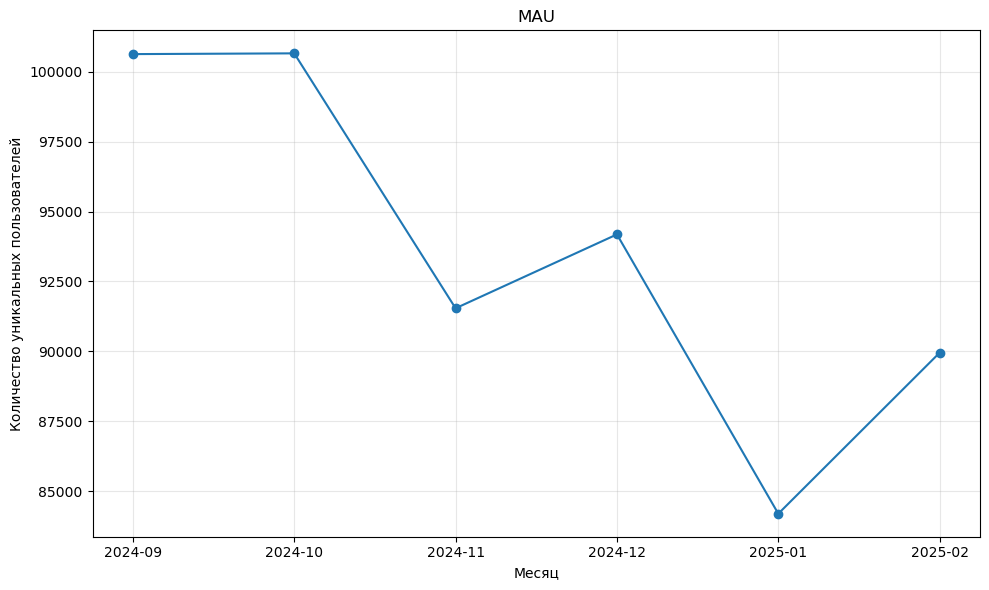

In [134]:
mau['month_str'] = mau['month'].astype(str)

plt.figure(figsize = (10,6))
plt.plot(mau['month_str'], mau['client_id'], marker = 'o')
plt.title('MAU')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных пользователей')
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

In [122]:
mau_by_platform = df.groupby(['month', 'platform_general'])['client_id'].nunique().reset_index()

mau_by_platform['month_str'] = mau_by_platform['month'].astype(str)

In [124]:
mau_by_platform

,month,platform_general,client_id,month_str
0,2024-09,Android-X,81937,2024-09
1,2024-09,DESKTOP_VERS_2,5,2024-09
2,2024-09,Desktop,739,2024-09
3,2024-09,WEB_VERS_2,24,2024-09
4,2024-09,iPhone-X,8068,2024-09
5,2024-09,web,10969,2024-09
6,2024-10,Android-X,81997,2024-10
7,2024-10,DESKTOP_VERS_2,20,2024-10
8,2024-10,Desktop,1272,2024-10
9,2024-10,WEB_VERS_2,324,2024-10


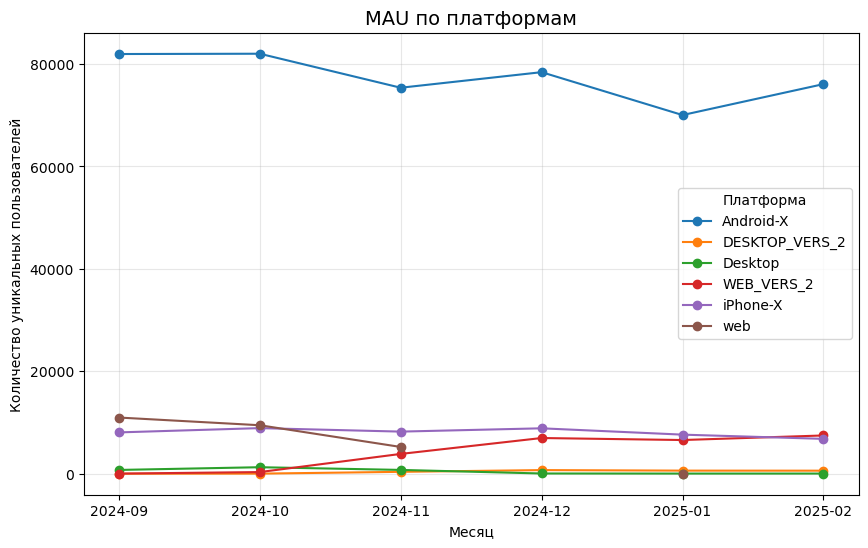

In [132]:
pivot_df = mau_by_platform.groupby(['month_str', 'platform_general'])['client_id'].sum().unstack()

pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('MAU по платформам', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных пользователей')
plt.grid(alpha=0.3)
plt.legend(title='Платформа')
plt.show()

***Задание 3***

Проанализировать полученные данные, выявить необычные вещи/события. 

Предположить, какие могли быть причины. Найти взаимосвязь между ростом/падением некоторых платформ.

На графике MAU видно:
- Пик активности наблюдается **в сентябре-октябре 2024 года**
- Затем происходит **снижение числа активных пользователей в ноябре**, кратковременный рост в декабре и **резкое падение в январе 2025 года** 
- В феврале фиксируется **частичное восстановление**

Вероятные причины могут быть связаны с:
1. **Сезонностью** - в январе обычно падает активность в связи праздниками
2. **Техническими сбоями** - в конце 2024 года ,вероятно, начался переход на новую версию плтаформы, что могло временно снизить количество активных пользователей

Если смотреть отдельно по платформам, то:
- **Android-X** - уверенный лидер, именно он больше всего влияет на общую динамику; его спады в ноябре и январе совпадают с падением общего MAU
- **iPhone-X** держится стабильно, без сильных колебаний. 
- **Web** постепенно теряет активность, а после ноября данные вовсе перестали фиксироваться; возможно, после ноября пользователи перешли на новую платформу
- **WEB_VERS_2**, наоборот, немного растет - похоже, часть пользователи с web перешли как раз на эту платформу 
- **Desktop** и **DESKTOP_VERS_2** почти не влияют на общую картину, доля очень маленькая